In [19]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [20]:
data = pd.read_csv("https://www.gasnetworks.ie/corporate/open-data/2024-Q3-Daily-Gas-Demand.csv")

# renaming columns
data.columns = ['date','l_business','xs_business_houses','xl_business','power_gen','total']

# Rounding the data to 2 decimal places
data = data.round(2)

# Formatting the date column
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')

In [21]:
# Monthly gas consumption 
month_houses = data.groupby(data['date'].dt.to_period('M')).mean()

# Monthly gas consumption for houses and xs business
month_houses = month_houses.drop(columns=['date','xl_business','power_gen','total','l_business'])
month_houses=month_houses.reset_index()
month_houses['date'] = month_houses['date'].dt.to_timestamp()

print(month_houses['date'].min())
print(month_houses['date'].max())

2018-01-01 00:00:00
2024-09-01 00:00:00


In [22]:
# set date as index
month_houses = month_houses.set_index('date')

month_houses = month_houses.asfreq('MS')
month_houses = month_houses.sort_index()
month_houses



,xs_business_houses
date,
2018-01-01,59.766129
2018-02-01,63.587500
2018-03-01,59.383871
2018-04-01,38.226333
2018-05-01,20.112581
...,...
2024-05-01,16.950000
2024-06-01,12.494333
2024-07-01,10.300000


In [23]:
# Verifying that a temporary index is complete for data
start_date = month_houses.index.min()
end_date = month_houses.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=month_houses.index.freq)
is_index_complete = (month_houses.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")

# Missing values
print(f'Number of rows with missing values: {month_houses.isnull().any(axis=1).mean()}')

Index complete: True
Number of rows with missing values: 0.0


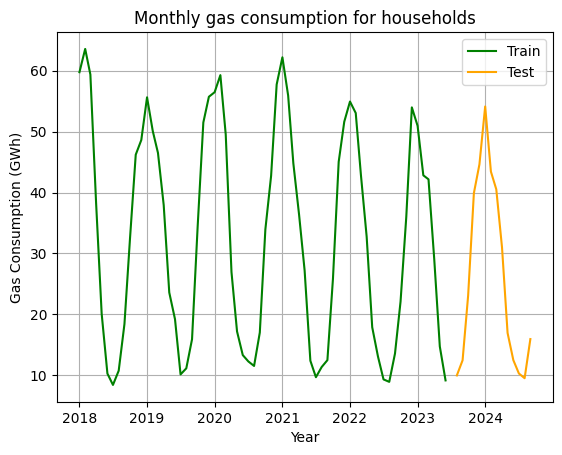

In [24]:
# Splitting data for traning and testing
# Data before 2023-07-01 will be the training one. 

train = month_houses[month_houses.index < pd.to_datetime("2023-07-01", format='%Y-%m-%d')]
test = month_houses[month_houses.index > pd.to_datetime("2023-07-01", format='%Y-%m-%d')]

# plotting train and test
fig,ax =plt.subplots()
ax.plot(train.index,train['xs_business_houses'],color = 'green' ,label='Train')
ax.plot(test.index,test['xs_business_houses'],color='orange', label='Test')
ax.set_xlabel("Year")
ax.set_ylabel("Gas Consumption (GWh)")
ax.set_title("Monthly gas consumption for households")
ax.grid()
ax.legend(loc='upper right')
plt.show()

In [25]:
# This function checks date for stationary for  data
# Ref.:https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


check_stationarity(month_houses)

ADF Statistic: -0.42909885899478023
p-value: 0.9051257710026992
Non-Stationary


In [26]:
# Differencing the Data
# Differencing involves subtracting the previous observation from
# the current observation to remove trends and seasonality.

# First-order differencing
month_houses = month_houses.diff()

# Drop the first row with NaN
diff_train = month_houses.dropna()

# Check stationarity again
check_stationarity(diff_train)

ADF Statistic: -6.843704076357978
p-value: 1.764640684383451e-09
Stationary


In [27]:
#diff_train

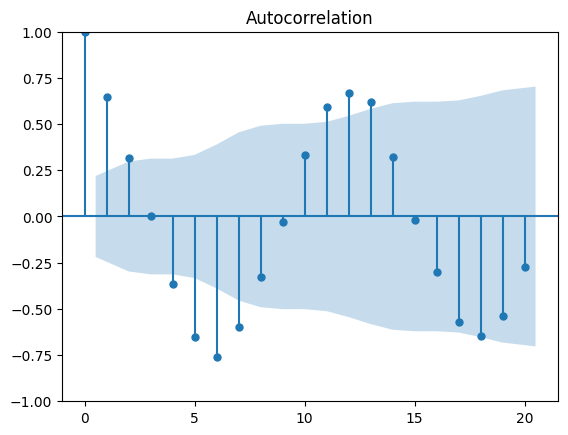

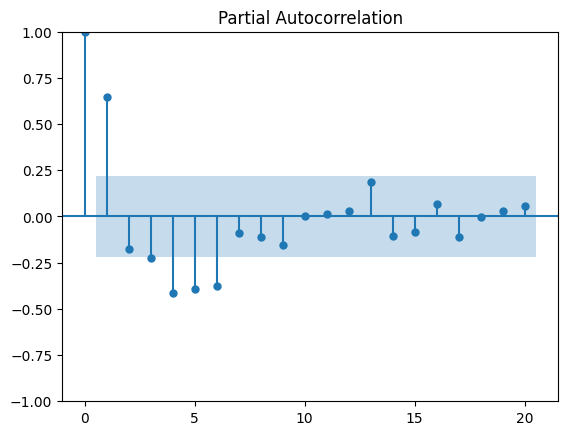

In [28]:
# Plot ACF and PACF
plot_acf(diff_train)
plot_pacf(diff_train)
plt.show()

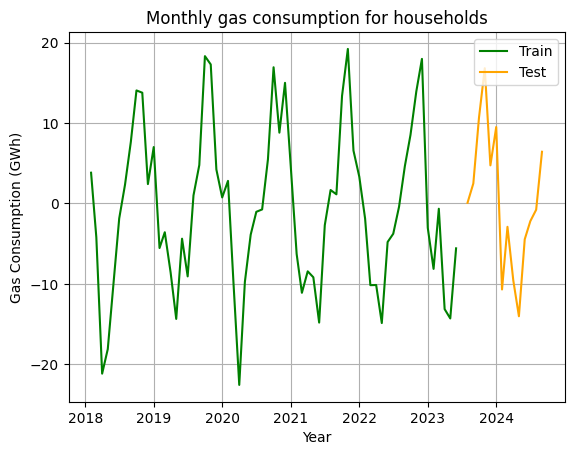

In [29]:
# Splitting data for traning and testing
# Data before 2023-07-01 will be the training one. 

train = diff_train[diff_train.index < pd.to_datetime("2023-07-01", format='%Y-%m-%d')]
test = diff_train[diff_train.index > pd.to_datetime("2023-07-01", format='%Y-%m-%d')]

# plotting train and test
fig,ax =plt.subplots()
ax.plot(train.index,train['xs_business_houses'],color = 'green' ,label='Train')
ax.plot(test.index,test['xs_business_houses'],color='orange', label='Test')
ax.set_xlabel("Year")
ax.set_ylabel("Gas Consumption (GWh)")
ax.set_title("Monthly gas consumption for households")
ax.grid()
ax.legend(loc='upper right')
plt.show()

In [30]:
# Define SARIMA parameters
# Assuming monthly seasonality
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12 

# Fit the SARIMA model
model = SARIMAX(diff_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65567D+00    |proj g|=  9.83172D-02

At iterate    5    f=  2.52629D+00    |proj g|=  9.63560D-02

At iterate   10    f=  2.51331D+00    |proj g|=  2.37382D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   3.824D-05   2.513D+00
  F =   2.5132990039446943     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [31]:
# Getting prediction for test data
forecast_test = results.get_prediction(start=test.index[0], end=test.index[-1])
forecast_test_mean = forecast_test.predicted_mean
forecast_test_ci = forecast_test.conf_int()

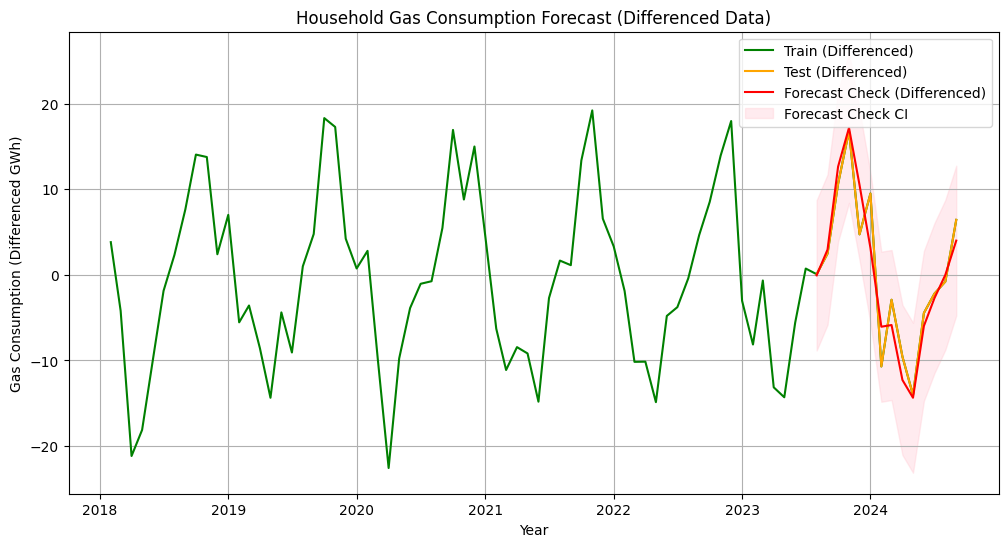

In [32]:
# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(diff_train.index, diff_train['xs_business_houses'], label='Train (Differenced)', color='green')
plt.plot(test.index, test['xs_business_houses'], label='Test (Differenced)', color='orange')
plt.plot(forecast_test_mean.index, forecast_test_mean, label='Forecast Check (Differenced)', color='red')

# confidence interval 
plt.fill_between(forecast_test_ci.index, 
                 forecast_test_ci.iloc[:, 0], 
                 forecast_test_ci.iloc[:, 1], 
                 color='pink', alpha=0.3, label='Forecast Check CI')

plt.title("Household Gas Consumption Forecast (Differenced Data)")
plt.xlabel("Year")
plt.ylabel("Gas Consumption (Differenced GWh)")
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [33]:
# Making predictions

# Forecast future values
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

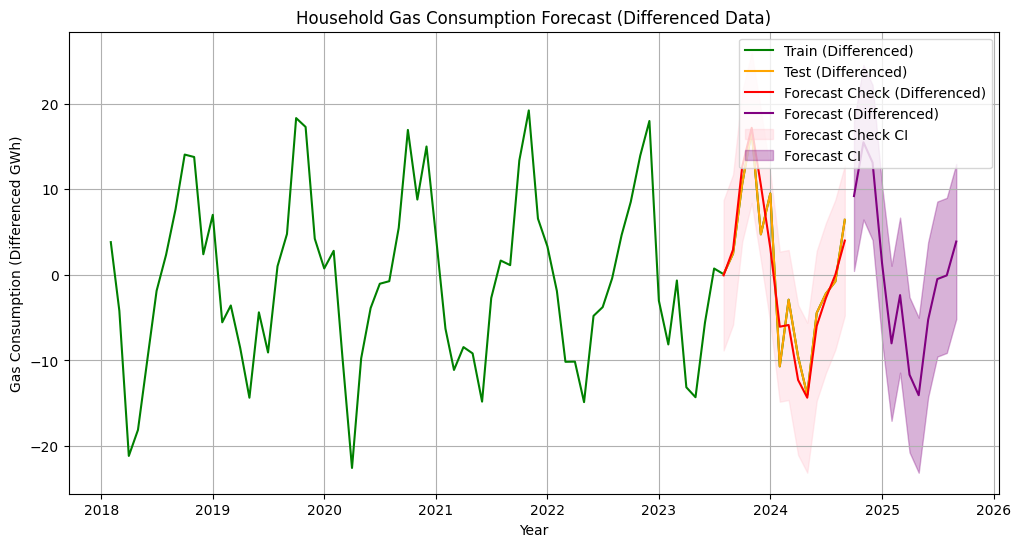

In [34]:
# Plot the differenced data
plt.figure(figsize=(12, 6))

plt.plot(diff_train.index, diff_train['xs_business_houses'], label='Train (Differenced)', color='green')
plt.plot(test.index, test['xs_business_houses'], label='Test (Differenced)', color='orange')
plt.plot(forecast_test_mean.index, forecast_test_mean, label='Forecast Check (Differenced)', color='red')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast (Differenced)', color='purple')

# confidence intervals
plt.fill_between(forecast_test_ci.index, 
                 forecast_test_ci.iloc[:, 0], 
                 forecast_test_ci.iloc[:, 1], 
                 color='pink', alpha=0.3, label='Forecast Check CI')

plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='purple', alpha=0.3, label='Forecast CI')


plt.title("Household Gas Consumption Forecast (Differenced Data)")
plt.xlabel("Year")
plt.ylabel("Gas Consumption (Differenced GWh)")
plt.legend(loc='upper right')
plt.grid()
plt.show()